# ML - Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn import datasets

sns.set_theme(style="whitegrid")

## Motivation

Space Shuttle Challenger Disaster

<p><img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Challenger_explosion.jpg" alt="Challenger explosion.jpg" height="720" width="889"></a><br>By Kennedy Space Center</p>

In [2]:
# filepath = Path().resolve().parent / "data" / "challenger.txt"  # If you are running locally
filepath = "https://raw.githubusercontent.com/aoguedao/neural_computing_workshop/main/data/Challenger.txt"
challenger = pd.DataFrame(
    np.loadtxt(filepath, skiprows=1).astype(int),
    columns=["temp_f", "nm_bad_rings"]
)
challenger.head()

,temp_f,nm_bad_rings
0,53,3
1,56,1
2,57,1
3,63,0
4,66,0


/tmp/ipykernel_12650/3810344009.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


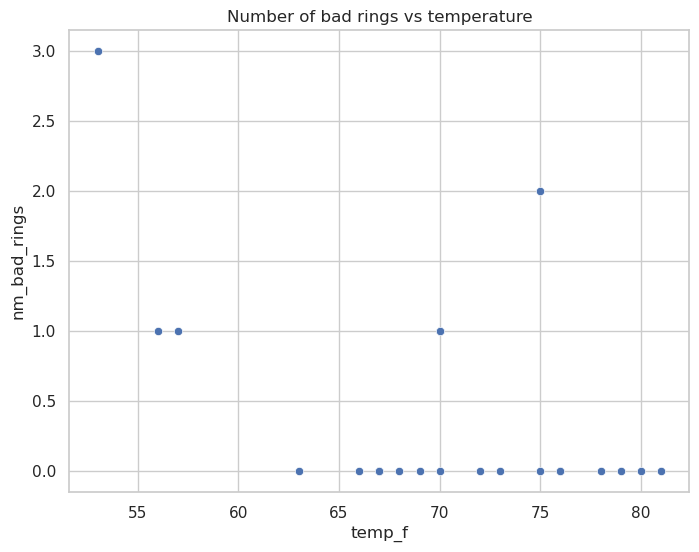

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x="temp_f",
    y="nm_bad_rings",
    data=challenger,
    ax=ax
)
ax.set_title("Number of bad rings vs temperature")
fig.show()


In [4]:
challenger = challenger.assign(
    failure=lambda x: x["nm_bad_rings"].ne(0),
    is_failure=lambda x: x["failure"].astype(int),
)

/tmp/ipykernel_12650/2432193437.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


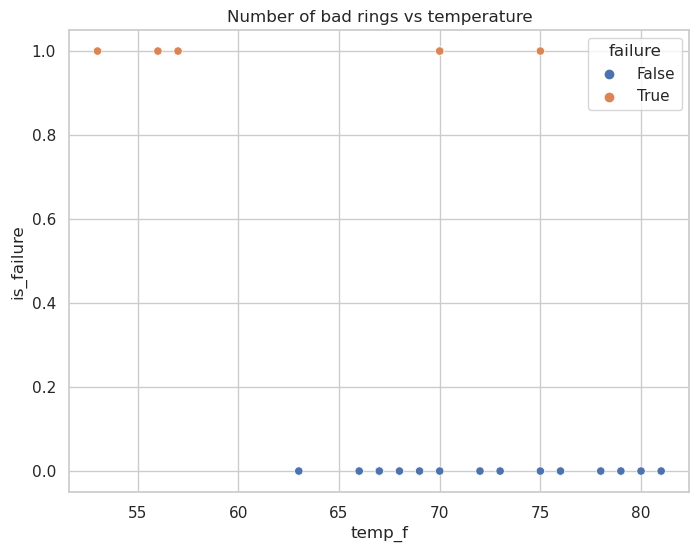

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x="temp_f",
    y="is_failure",
    hue="failure",
    data=challenger,
    ax=ax
)
ax.set_title("Number of bad rings vs temperature")
fig.show()

## Logistic Regression

Similar to Linear Regression we are looking for a model that approximates
$$ Y \approx f_\beta(X) $$

where
$$
X = \begin{bmatrix} 
1 & x^{(1)}_1 & \dots & x^{(1)}_p \\ 
1 & x^{(2)}_1 & \dots & x^{(2)}_p \\
\vdots & \vdots & & \vdots \\
1 & x^{(n)}_1 & \dots & x^{(n)}_p
\end{bmatrix}
\quad , \quad
Y = \begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix}
\quad \text{and} \quad
\beta = \begin{bmatrix}\beta_0 \\ \beta_1 \\ \vdots \\ \beta_n\end{bmatrix}
$$

but we want to train a non-linear function

$$f_{\beta}(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_p x_n)}}$$

and to minimize the cost function
$$J(\beta) = \frac{1}{2} \sum_{i=1}^{n} \left( y^{(i)} - f_{\beta}(x^{(i)})\right)^2$$

Notice that we can write

$$Y \approx f_\beta(X) = g(X \beta)$$

where $g(z)$ is a _sigmoid function_,

$$g(z) = \frac{1}{1+e^{-z}}$$

### Decision

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

/tmp/ipykernel_12650/966449380.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


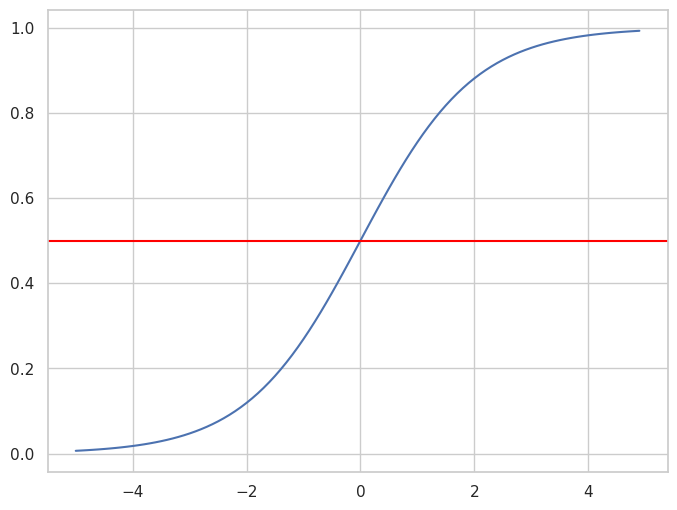

In [7]:
x = np.arange(-5, 5, 0.1)
y = sigmoid(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y)
ax.axhline(y=0.5, xmin=-5, xmax=5, color="red")
fig.show()

## Optimization

First of all, the derivative of this sigmoid function is easy to compute.

$$
\begin{align*}
g'(z) &= \frac{-1}{(1+e^{-z})^2} (-e^{-z}) \\
      &= \frac{e^{-z}}{(1+e^{-z})^2} \\
      &= \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}} \\
      &= \frac{1}{1+e^{-z}} \left(1 - \frac{1}{1+e^{-z}} \right) \\
      &= g(z)(1-g(z))
\end{align*}
$$

In order to compute the jacobian we need the partial derivatives,

$$
\begin{align*}
\frac{\partial J(\beta)}{\partial \beta_k}
&= \sum_{i=1}^{m} \left( y^{(i)} - f_{\beta}(x^{(i)}) \right) \frac{\partial}{\partial \beta_k} f_{\beta}(x^{(i)}) \\
&= \sum_{i=1}^{m}  \left( y^{(i)} - f_{\beta}(x^{(i)}) \right) \frac{\partial}{\partial \beta_k} g(\beta^T x^{(i)}) \\
&= \sum_{i=1}^{m}  \left( y^{(i)} - f_{\beta}(x^{(i)}) \right) f_{\beta}(x^{(i)}) \left(1-f_{\beta}(x^{(i)})\right) \frac{\partial}{\partial \beta_k} (\beta^T x^{(i)}) \\
&= \sum_{i=1}^{m}  \left( y^{(i)} - f_{\beta}(x^{(i)}) \right) f_{\beta}(x^{(i)}) \left(1-f_{\beta}(x^{(i)})\right) x^{(i)}_k
\end{align*}
$$

then

$$\nabla_{\beta} J(\beta) = X^\top  \Big[ (Y - g(X\beta)) \odot g(X\beta) \odot (1 - g(X\beta)) \Big]$$

where $\odot$ is a element-wise multiplication, usually called Hadamard product.

Then, the gradient descent algorithm for the binary logistic regression is

$$
\begin{align*}
\beta^{(n+1)} & = \beta^{(n)} - \alpha \nabla_{\beta} J(\beta^{(n)}) \\
\nabla_{\beta} J(\beta) &= X^\top  \Big[ (Y - g(X\beta)) \odot g(X\beta) \odot (1-g(X\beta)) \Big]
\end{align*}
$$


## Implementation

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
X = challenger[["temp_f"]]
y = challenger["is_failure"]
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [10]:
model.coef_.T

array([[-0.17014123]])

In [11]:
%%timeit
LogisticRegression().fit(X, y)

1.57 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
model.score(X, y)

0.7916666666666666

In [13]:
# Predicting values
y_pred = model.predict(X)
y_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

## Multi-Label Classification

In [14]:
digits_X, digits_y = datasets.load_digits(return_X_y=True, as_frame=True)
digits = pd.concat([digits_X, digits_y], axis=1)
digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [15]:
sns.set_style("white")

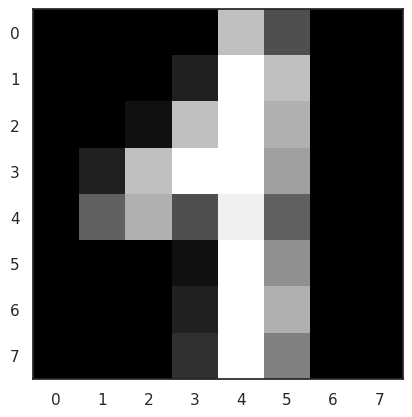

In [16]:
digit_images = datasets.load_digits().images
i = 42
plt.imshow(digit_images[i], cmap=plt.cm.gray)

In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(digits_X, digits_y)

/home/alonsolml/mambaforge/envs/nc-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [18]:
model.predict(digits_X.loc[[i], :])

array([1])

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(digits_X)
confusion_matrix(digits_y, y_pred, labels=model.classes_)

array([[178,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 182,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 177,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 183,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 182,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 179,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 174,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 180]])

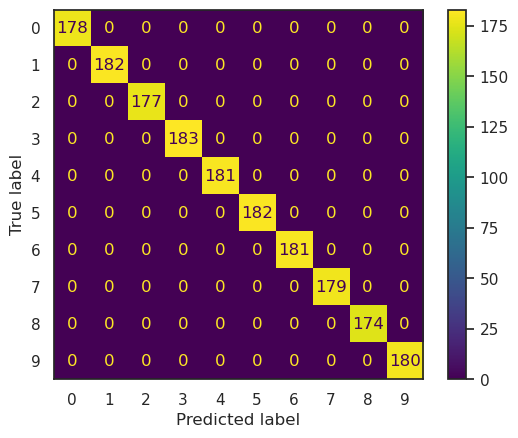

In [20]:
ConfusionMatrixDisplay.from_estimator(model, digits_X, digits_y)

In [21]:
from sklearn.metrics import classification_report

y_true = digits_y.values
y_pred = model.predict(digits_X)
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[str(x) for x in model.classes_]
    )
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       177
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00       181
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       179
           8       1.00      1.00      1.00       174
           9       1.00      1.00      1.00       180

    accuracy                           1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797



## More Algorithms

### K Nearest Neighbors

K Nearest Neighbors (kNN) is a non-parametric algorithm. Once the hyperparameter $k$ has been fixed, there are no more parameters. The idea is simple: the output label is the most common label among the 𝑘 nearest neighbors. In the following example, if $k=3$ the green circle is labeled as red, but if $k=5$ then it is labeled as blue.

![KNN](../../images/KnnClassification.png)

[Source](https://commons.wikimedia.org/wiki/File:KnnClassification.svg)

The algorithm is really simple. The training phase consists only of storing the feature matrix and its labels.

For the prediction phase we need to compute the distance with every training vector and then find the nearest neighbors.

![kNN Algorithm](../../images/knn_algorithm.jpg)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(digits_X, digits_y)

KNeighborsClassifier()

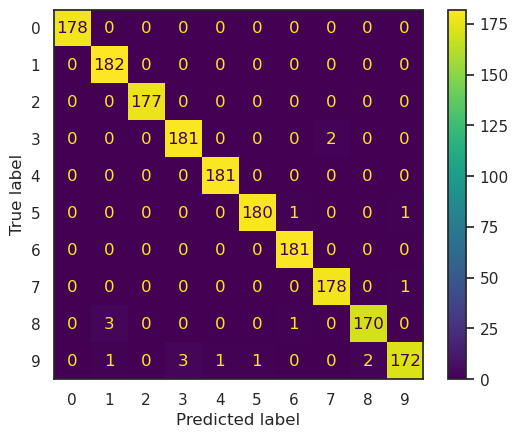

In [23]:
ConfusionMatrixDisplay.from_estimator(knn, digits_X, digits_y)